# Reaktions-Ratenkonstanten - Teil 3

Im Folgenden werden nun je zwei Reaktionen in mehreren Stufen unterschiedlich "schneller" oder "affiner", also mächtiger gegenüber den anderen, gemacht.

In [1]:
%matplotlib inline

from context import *
from pandas import DataFrame
from Gillespie.Gillespie import Gillespie
import matplotlib.pyplot as plt
import numpy as np

# initialise constants
L = DataFrame({"reaction1":[1, 1, 0, 0, 0],
            "reaction2":[0, 1, 1, 0, 0],
            "reaction3":[0, 0, 0, 1, 0],
            "reaction4":[0, 0, 0, 0, 1]}, index = ["target","probe","interferer","tp-complex","ip-complex"])
R = DataFrame({"reaction1":[0, 0, 0, 1, 0],
            "reaction2":[0, 0, 0, 0, 1],
            "reaction3":[1, 1, 0, 0, 0],
            "reaction4":[0, 1, 1, 0, 0]}, index = ["target","probe","interferer","tp-complex","ip-complex"])
N = R - L

rConstants = {"reaction1": 0.08, "reaction2": 0.08, "reaction3": 0.08, "reaction4": 0.08}

quantities = {"target": [50], "probe": [50], "interferer": [50], "tp-complex": [50], "ip-complex": [50]}

colours = {"target":"red", "probe":"cornflowerblue", "interferer":"goldenrod", "tp-complex":"purple", "ip-complex":"forestgreen"}

In [8]:
# Verschiedene Ratenkonstanten-Kombinationen speichern
r1_r2_changed_rConstants = DataFrame({"reaction1": [0.8, 1, 1.5, 2.5, 4.0],
                                      "reaction2": [0.8, 1, 1.5, 2.5, 4.0],
                                      "reaction3": [0.8, 0.8, 0.8, 0.8, 0.8],
                                      "reaction4": [0.8, 0.8, 0.8, 0.8, 0.8]},
                                      index=["Kombi 1", "Kombi 2", "Kombi 3", "Kombi 4", "Kombi 5"])

das_dict_rConst_r1_r2_changed = dict()
# Für jede Kombination
for kombi in r1_r2_changed_rConstants["reaction1"].keys():

    rConstants.clear()
    # Erstelle das ursprüngliche rConstants-dict
    rConstants = dict()
    for reaction in r1_r2_changed_rConstants.keys():
        rConstants.update({reaction: r1_r2_changed_rConstants[reaction][kombi]})

    temp = []
    # Speichere die Gillespie-Läufe
    for x in range(200):
        gillespie_obj = Gillespie(L, N, rConstants, quantities)
        gillespie_obj.run_time_sec(0.5)
        temp.append(gillespie_obj)
    # Als key wird der Name der aktuell berechneten Kombination ausgewählt
    das_dict_rConst_r1_r2_changed.update({kombi: temp})

In [ ]:
for kombi in das_dict_rConst_r1_r2_changed.keys():
    figure, axs = plt.subplots(3, 3, sharex="col", sharey="row", gridspec_kw={"hspace": 0, "wspace": 0}, figsize=(10, 6))
    figure.suptitle("Ratenkonstante - #50 | c[r1..r4] = [" + str(r1_r2_changed_rConstants["reaction1"][kombi]) + ", " + str(r1_r2_changed_rConstants["reaction2"][kombi]) + ", 0.8, 0.8]")
    for i, ax in enumerate(axs.flat):
        # Zur Demonstration einfach die ersten neun Gillespies plotten
        current_gil = das_dict_rConst_r1_r2_changed[kombi][i]
        for species in current_gil.quantities.keys():
            ax.plot(current_gil.times, current_gil.quantities[species], colours[species], label=species)
        
        ax.set(xlabel='time [rel]', ylabel='total amount')
        ax.label_outer()

    plt.legend(loc=(1.1, 0.1), mode="expand", borderaxespad=0.)

In [ ]:
for case in das_dict_rConst_r1_r2_changed.keys():
    # Für 6 Plots Platz, ich brauche aber nur die 5 für meine Spezies
    figure, axs = plt.subplots(3, 2, gridspec_kw={"hspace": 0.6, "wspace": 0.3}, figsize=(10,10))  # sharex="col", sharey="row"
    figure.suptitle("Ratenkonstante - #50 | c[r1..r4] = [" + str(r1_r2_changed_rConstants["reaction1"][case]) + ", " + str(r1_r2_changed_rConstants["reaction2"][case]) + ", 0.8, 0.8]")

    for i, species in enumerate(quantities):
        ax = axs.flat[i]
        for gilles in das_dict_rConst_r1_r2_changed[case]:
            ax.plot(gilles.times, gilles.quantities[species], colours[species], label = species)
        ax.set(xlabel='time [rel]', ylabel='total amount')
        ax.set_title(species)
    
    sixth_ax = axs.flat[-1]
    sixth_ax.set(xlabel='time [rel]', ylabel='total amount')
    sixth_ax.set_title('probe-complexes and total output')
    for gilles in das_dict_rConst_r1_r2_changed[case]:
        sixth_ax.plot(gilles.times, gilles.quantities['tp-complex'], colours['tp-complex'], label='tp-complex')
        sixth_ax.plot(gilles.times, gilles.quantities['ip-complex'], colours['ip-complex'], label='ip-complex')
        total_output = []
        for i in range(len(gilles.quantities["tp-complex"])):
            total_output.append(gilles.quantities["tp-complex"][i] + gilles.quantities["ip-complex"][i])
        sixth_ax.plot(gilles.times, total_output, 'brown', label='total output')

In [9]:
def single_gillespie_count(gilles, grid, analyte):
    norm_time = gilles.times / np.float64(gilles.tmax)
    norm_analyte = gilles.quantities[analyte] / np.float64(100)
    grid_time = norm_time * len(grid)
    grid_time = grid_time.astype(int)
    grid_analyte = norm_analyte * len(grid)
    grid_analyte = grid_analyte.astype(int)

    data = []
    for x in range(len(grid_time)):
        data.append((grid_time[x], grid_analyte[x]))
    
    for date in data:
        try:
            grid[date[0], date[1]] += 1
        except IndexError:
            continue
            print('Data pair ', date, ' is out of bounds for grid with size ', len(grid), ' x ', len(grid[0]))

In [ ]:
import numpy as np
grid = np.zeros((10, 10), dtype=np.int32)
print('grid länge: ', len(grid), '\ngrid größe: ', grid.size, '\ngrid tiefe: ', len(grid[0]))
grid[0] = 1
grid[2, 4] = 5
print(grid)

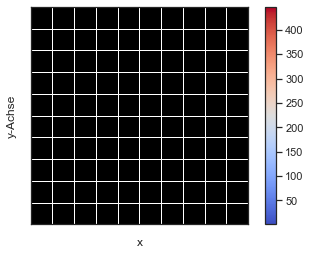

In [10]:
grid_size = 200
grid = np.zeros((grid_size, grid_size), dtype=np.int32)

for gilles in das_dict_rConst_r1_r2_changed['Kombi 1']:
    single_gillespie_count(gilles, grid, 'tp-complex')

plt.figure()
# Convert to float32 so we can use nan instead of 0.
grid = grid.astype(np.float32)
grid[grid==0] = np.nan
plt.grid(color='w')
plt.imshow(grid.T[::-1,:], extent=[0,1,0,1], cmap=plt.cm.coolwarm,
            interpolation='gaussian')
ax = plt.gca()
ax.set_fc('black')
ax.set_xticks(np.linspace(0,1,11))
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('x')
ax.set_ylabel('y-Achse')
plt.colorbar()
fig = plt.gcf()

#plt.savefig("eye-diagram.png", bbox_inches='tight')
plt.show()

In [ ]:
maxi, mini = 0, 1020

for entry in grid.flat:
    if entry > maxi:
        maxi = entry
    if entry < mini:
        mini = entry
print(maxi, mini)

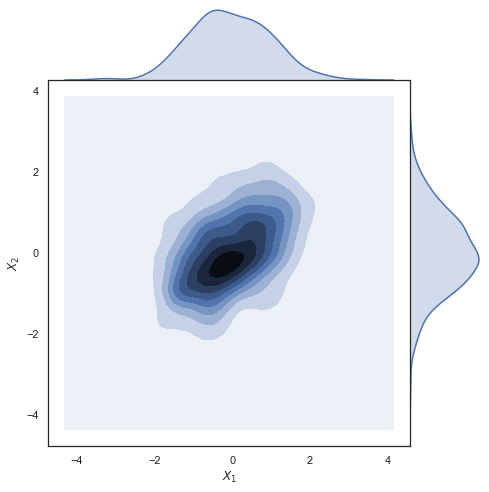

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")

# Generate a random correlated bivariate dataset
rs = np.random.RandomState(5)
mean = [0, 0]
cov = [(1, .5), (.5, 1)]
x1, x2 = rs.multivariate_normal(mean, cov, 500).T
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(x2, name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)

In [ ]:
print(x1)
print(x2)

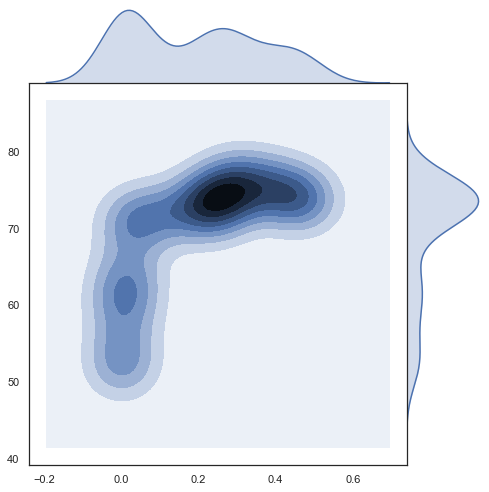

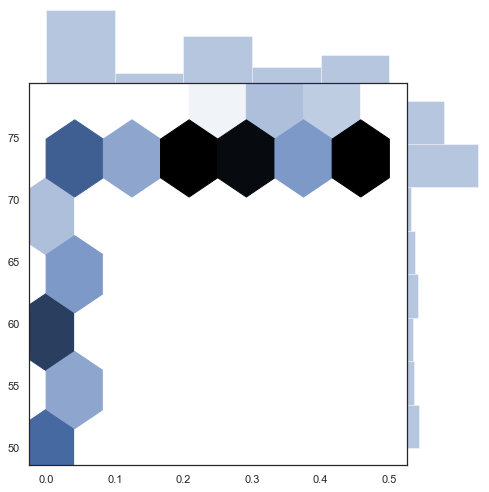

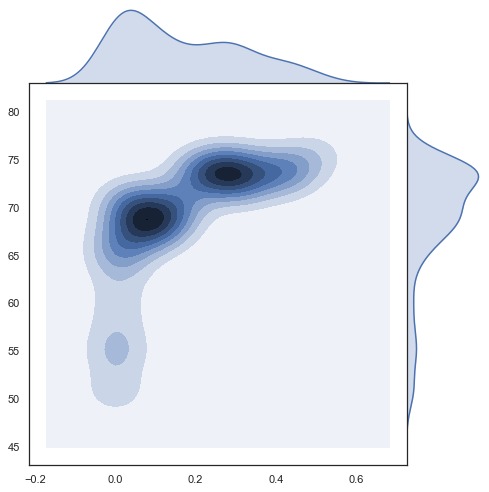

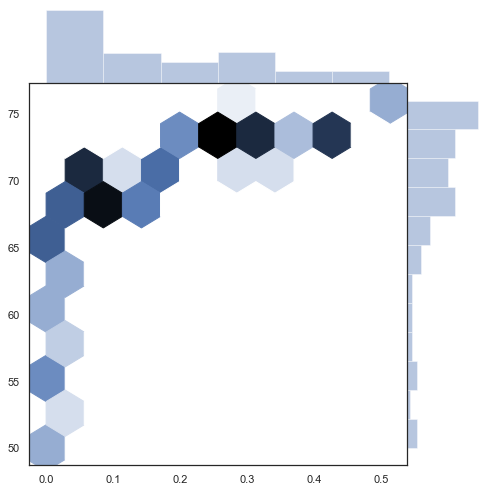

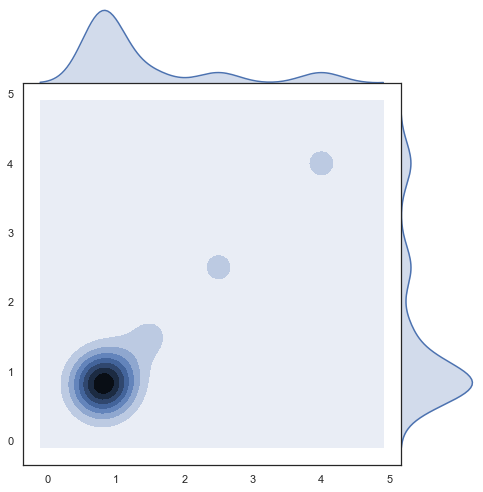

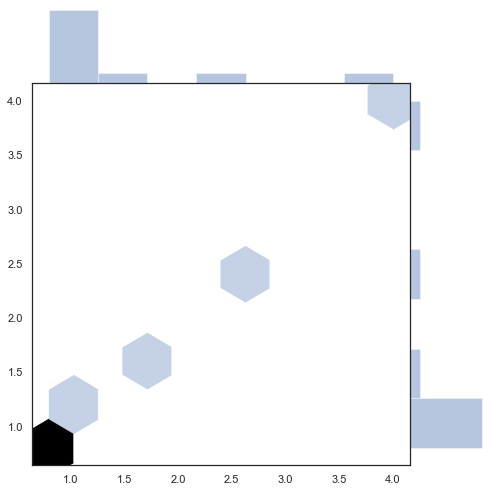

In [12]:
sns.set(style="white")

gilles1 = das_dict_rConst_r1_r2_changed['Kombi 1'][0]
gilles2 = das_dict_rConst_r1_r2_changed['Kombi 1'][1]
# print(type(gilles1))
time_serie = pd.Series(gilles1.times, name='$time_{rel}$')
quantity_serie = pd.Series(gilles1.quantities['tp-complex'], name='quantity')
# # Generate a random correlated bivariate dataset
# rs = np.random.RandomState(5)
# mean = [0, 0]
# cov = [(1, .5), (.5, 1)]
# x1, x2 = rs.multivariate_normal(mean, cov, 500).T
# x1 = pd.Series(x1, name="$X_1$")
# x2 = pd.Series(x2, name="$X_2$")

# Show the joint distribution using kernel density estimation
# f = sns.jointplot(time_serie, quantity_serie, kind="kde", height=7, space=0)
g1 = sns.jointplot(gilles1.times, gilles1.quantities['tp-complex'], kind="kde", height=7, space=0)
g11 = sns.jointplot(gilles1.times, gilles1.quantities['tp-complex'], kind="hex", height=7, space=0)
g2 = sns.jointplot(gilles2.times, gilles2.quantities['tp-complex'], kind="kde", height=7, space=0)
g22 = sns.jointplot(gilles2.times, gilles2.quantities['tp-complex'], kind="hex", height=7, space=0)
g3 = sns.jointplot(r1_r2_changed_rConstants, r1_r2_changed_rConstants, kind='kde', height=7, space=0)
g33 = sns.jointplot(r1_r2_changed_rConstants, r1_r2_changed_rConstants, kind='hex', height=7, space=0)

C:\Users\Johannes Bachelor.LAPTOP-OLVU0UN8\Dokumente\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


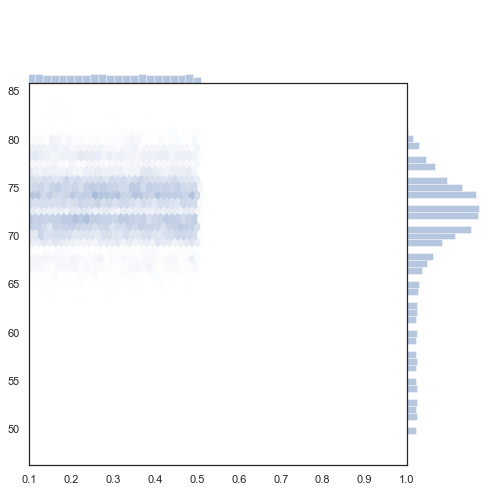

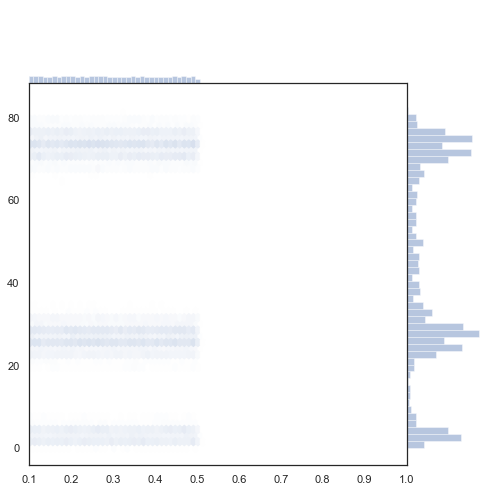

In [35]:
def plot_distribution(x_gillespies, analyte=None, kind='hex'):

    list_analyte = []
    list_time = []

    s_analyte = pd.Series()

    if analyte is None:
        for single_gillespie in x_gillespies:
            for species in single_gillespie.quantities.keys():
                list_analyte.append([quant for quant in single_gillespie.quantities[species]])
                list_time.append(single_gillespie.times)
    
    elif analyte in x_gillespies[0].quantities.keys():
        for single_gillespie in x_gillespies:
            list_analyte.append(single_gillespie.quantities[analyte])
            list_time.append(single_gillespie.times)
    else:
        raise KeyError("Could not map parameter analyte to any key in the quantity's dictionary.")
    # print(list_analyte)
    # print(list_time)

    df_data = pd.DataFrame(data=[list_time, list_analyte])
    g = sns.jointplot(x=pd.DataFrame(list_time), y=pd.DataFrame(list_analyte), kind=kind, height=7, space=0)  # data=df_data, xlim=0.1
    # g2 = sns.jointplot()

df_data = pd.DataFrame(das_dict_rConst_r1_r2_changed)
df_single_variation = df_data['Kombi 1']

# print(type(df_single_variation))

plot_distribution(df_single_variation, analyte='tp-complex')
plot_distribution(df_single_variation)


# data_frame = pd.DataFrame(gilles1.quantities)
# frame2 = pd.DataFrame()
# for x in range(len(gilles1.quantities)):
#     frame2[x] = gilles1.times
# print(frame2)
# g4 = sns.jointplot(frame2, data_frame, kind="kde", height=7, space=0)

Vielleicht wäre es schlau ganz am Anfang ein Objekt *Reaktionssystem* einzubauen, um darin dann die Reaktionskonstanten, räumlichen Dimensionen, Temperatur, Diffusionskonstanten usw. abzulegen.  
U.a. könnten dort auch zwei Listen hinterlegt werden, die alle messbaren, also Sonden-bindenden, Analyten einfassen und dann unterscheiden, ob die entstehende Signalkomponente gewollt ist, oder nicht. Damit wäre irgendwo definiert, was richtiges Signal und Rauschen werden soll. Über diese Listen könnte man wiedrum dann hier iterieren, um am Ende das SNR zu berechnen.

In [86]:
# Kleine statistische Auswertung der Kurven und SNR für diesen einen Versuchsaufbau

n_runs_tps = [gilles.quantities['tp-complex'] for gilles in df_single_variation]
n_runs_ips = [gilles.quantities['ip-complex'] for gilles in df_single_variation]
print(len(n_runs_ips))

# Summe der aller Sonden-bindenden Spezies, die auch an eine solche gebunden sind
quan_tity_signal = []
for x_i in range(len(n_runs_tps)):
    quan_tity_signal.append([n_runs_tps[x_i][y] + n_runs_ips[x_i][y] for y in range(len(n_runs_tps[x_i]))])
# Nur Anzahl der Interferer, die an Sonden gebunden haben
quan_tity_background = n_runs_ips
# quan_tity_background = []
# for probe_complex in noisy_molecules:
#     continue # to calculate the sum for all noisy complexes over all time steps

signal_mean_quantity = np.mean([np.mean(quan) for quan in quan_tity_signal])
print('Signal: Mittlere Anzahl: ', signal_mean_quantity)
print('Signal: Mittlere Varianz: ', np.mean([np.var(quan) for quan in quan_tity_signal]))
print('Signal: Mittlere Standardabweichung: ', np.mean([np.std(quan) for quan in quan_tity_signal]))
# print('Maximale gemittelte Anzahl: ', np.max([np.mean(quan) for quan in quan_tity_signal]))
# print([np.var(quan) for quan in quan_tity])
# print('Maximale Varianz: ', np.max([np.var(quan) for quan in quan_tity_signal]))
# print('Maximale Standardabweichung: ', np.max([np.std(quan) for quan in quan_tity_signal]))
background_mean_quantity = np.mean([np.mean(quan) for quan in quan_tity_background])
print('Anderes: Mittlere Anzahl: ', background_mean_quantity)
print('Anderes: Mittlere Varianz: ', np.mean([np.var(quan) for quan in quan_tity_background]))
print('Anderes: Mittlere Standardabweichung: ', np.mean([np.std(quan) for quan in quan_tity_background]))

print('SNR = ', signal_mean_quantity / background_mean_quantity)
# Signal-Mittel durch Standardabweichung
print('Alternative SNR = ', signal_mean_quantity / np.mean([np.std(quan) for quan in quan_tity_background]))

200
Signal: Mittlere Anzahl:  139.1364791195225
Signal: Mittlere Varianz:  174.66008738226913
Signal: Mittlere Standardabweichung:  13.202106894693143
Anderes: Mittlere Anzahl:  69.71568184432329
Anderes: Mittlere Varianz:  47.18419426801307
Anderes: Mittlere Standardabweichung:  6.822928336740272
SNR =  1.9957701831019519
Alternative SNR =  20.392487250715646


In [201]:
# pd.DataFrame mit allen Gillespie-Läufen, die ich für eine Kombination von input-Parametern habe
df_single_variation

# print(df_single_variation.shape)
# print(df_single_variation.keys())
# print(df_single_variation[0])
# for key in df_single_variation.keys():
#     print(len(df_single_variation[key].quantities['target']))

print(max([len(g.quantities['target']) for g in df_single_variation]))

print(df_data.shape, df_data.keys())

def make_time_quantity_tuples(list_times, list_quantities):
    """Makes from a time list and a quantity list a list og tuples with (time, quantity)"""

    if not len(list_times) == len(list_quantities):
        raise RuntimeError('Die Menge der Zeitpunkte entspricht nicht der Menge der Moleküldaten.')

    TupleList = []
    for x_i in range(len(list_times)):
        Time_Quantity = (list_times[x_i], list_quantities[x_i])
        TupleList.append(Time_Quantity)

    return TupleList

def shifting_variance_window(list_tuple_data, window_size=100, step=None):

    if step == None:
        step = int(window_size/10)
        if step < 1:
            step = 1
    if not isinstance(step, int):
        raise ValueError('Parameter "step" has to be an int, not ' + type(step))

    current_variance = np.inf
    snipping_position = 0
    # window shifting over all data
    for x_i in range(0, len(list_tuple_data) - window_size + 1, step):
        current_window = list_tuple_data[x_i:x_i+window_size]
        
        # print('len current_window:', len(current_window), 'from x_i =', x_i)
        
        new_variance = np.var([date[1] for date in current_window])
        
        # print('new_Var:', new_variance, 'curr_Var:', current_variance)
        
        # if the variance change between the windows is less than 2 percent
        if abs(new_variance - current_variance) < 0.02:  # 2 percent is yet an arbitrary value
            snipping_position = x_i
            break
        
        current_variance = new_variance
        
        # print('snipping_pos:', snipping_position)
        
    # return the time stamp from which the variance doesn't change dramatically
    return list_tuple_data[snipping_position][0]

MyTupleDict_perKombi = {}
# for every given combination of input parameters
for kombi in df_data.keys():
    dict_temp = {}
    # for all molecule species in the Gillespie runs
    for species in df_data[kombi][0].quantities.keys():
        list_species_tuples = []
        # for all Gillespie runs which were executed with one set of input params
        for gilles in df_data[kombi]:
            # for every date
            single_tuples_list = make_time_quantity_tuples(gilles.times, gilles.quantities[species])
            # sorting the data concerning to their time stamps
            # single_tuples_list.sort()
            list_species_tuples.extend(single_tuples_list)
        list_species_tuples.sort()
        dict_temp.update({species: list_species_tuples})
    
    # add all date points for all Gillespie runs of one combination of inputs to the dictionary
    MyTupleDict_perKombi.update({kombi:dict_temp})
    # TODO: Warum ist das Große Ding dann auf einmal leer? Wird nur der Verweis gespeichert, den ich dann lösche? : ObjektID checken
    # shifting_variance_window(dict_tples)

df_TupleData = DataFrame(MyTupleDict_perKombi)
# print(df_TupleData)

snipping_times = {}
for species in MyTupleDict_perKombi['Kombi 1'].keys():
    print('Spezies:', species, '\nMenge der Daten:', len(df_TupleData['Kombi 1'][species]))
    snipping_time = shifting_variance_window(df_TupleData['Kombi 1'][species], window_size=5000, step=1000)
    print('Zeitpunkt zum schneiden:', snipping_time)
    snipping_times.update({species:snipping_time})

# take the maximum value from snipping_times.values() to make sure that the system is in steady state for calc SNR
my_snipping_time = np.max(list(snipping_times.values()))
print('my time:', my_snipping_time)

# print('Zeitpunkt zum schneiden:', shifting_variance_window(df_TupleData['Kombi 1']['interferer'], window_size=5000, step=1000))

204
(200, 5) Index(['Kombi 1', 'Kombi 2', 'Kombi 3', 'Kombi 4', 'Kombi 5'], dtype='object')
Spezies: target 
Menge der Daten: 33178
Zeitpunkt zum schneiden: 0.22428111527924555
Spezies: probe 
Menge der Daten: 33178
Zeitpunkt zum schneiden: 0.2033418114960847
Spezies: interferer 
Menge der Daten: 33178
Zeitpunkt zum schneiden: 0.22428111527924555
Spezies:tp-complex 
Menge der Daten: 33178
Zeitpunkt zum schneiden: 0.22428111527924555
Spezies: ip-complex 
Menge der Daten: 33178
Zeitpunkt zum schneiden: 0.22428111527924555
my time: 0.22428111527924555


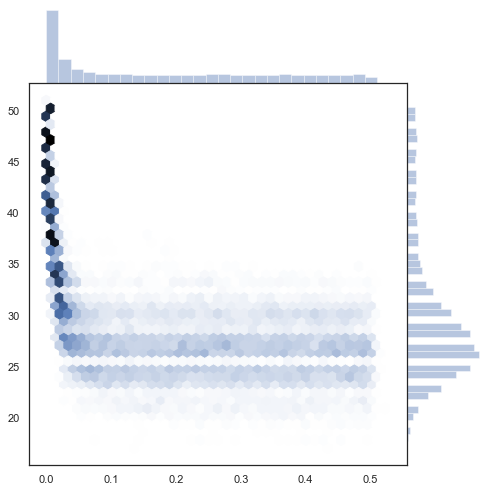

In [187]:
x1_line = [d[0] for d in df_TupleData['Kombi 1']['interferer']]
y1_line = [d[1] for d in df_TupleData['Kombi 1']['interferer']]

g1 = sns.jointplot(x=x1_line, y=y1_line, kind='hex', height=7, space=0)

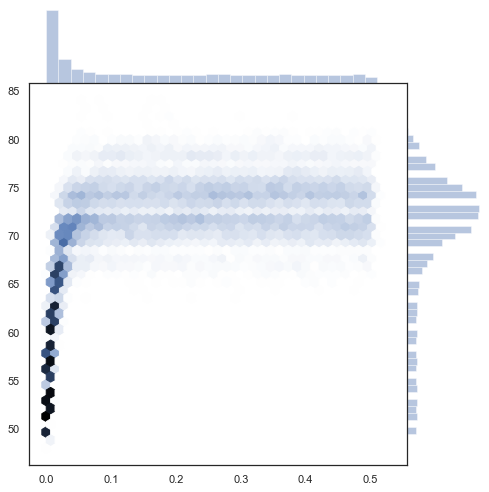

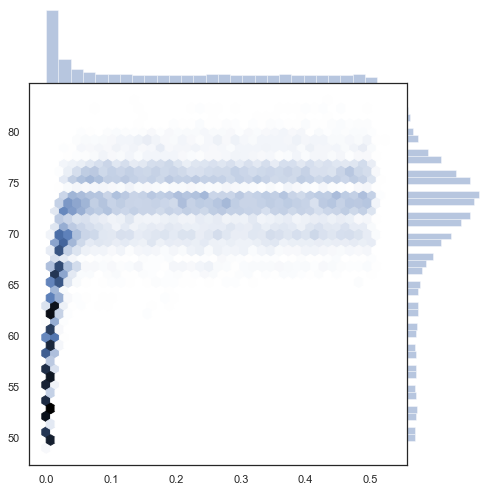

In [190]:
x2_line = [d[0] for d in df_TupleData['Kombi 1']['tp-complex']]
y2_line = [d[1] for d in df_TupleData['Kombi 1']['tp-complex']]
x3_line = [d[0] for d in df_TupleData['Kombi 1']['ip-complex']]
y3_line = [d[1] for d in df_TupleData['Kombi 1']['ip-complex']]

g2 = sns.jointplot(x=x2_line, y=y2_line, kind='hex', height=7, space=0)
g3 = sns.jointplot(x=x3_line, y=y3_line, kind='hex', height=7, space=0)